# Model

### Imports and plotting preferences

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from numpy.random import gamma, lognormal, normal
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from tqdm.notebook import tqdm

from graphs import load_data, occupancy_arrays

mpl.rc('font', family = 'serif', size = 15)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [2]:
save_dir = input('Full path to save directory:')

Full path to save directory:/Users/jacobdeasy/Desktop/current


In [3]:
# Global preferences
n_obs    = 11  # UPDATE THIS
n_future = 14
n_total  = n_obs + n_future

## Case number extrapolation

### Local plotting functions

In [4]:
def ci_plot(y, x_pred, y_pred, ci_l, ci_u, r,
            regions, dates, iter, ylabel='% ICU bed occupancy', obs=True, pct=False, y_max=2500):
#     plt.figure(figsize=(15, 15))
    ax = plt.subplot(331+iter)
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(x_pred), 3))
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]), np.concatenate([ci_l, ci_u[::-1]]),
             alpha=0.5, fc='b', ec='None', label='95% CI')
    plt.plot(x_pred, y_pred, 'b-', label='Fit (OLS)')
    if obs:
        plt.plot(np.arange(n_obs), y[:n_obs], 'r.', markersize=10, label='Observed')
        plt.text(15, 100, f'R$^{2}$={r:.2f}', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
    else:
        y_max = 100 if pct else 1000
        plt.plot([n_obs, n_obs], [0, y_max], 'r')
        plt.text(n_obs, y_max/2, 'Prediction\n window\n$\longrightarrow$', color='r')
    plt.xlim(0, x_pred.max())
    plt.ylim(0, y_max)
    plt.xticks(range(0, n_total, 3), dates[::3]) if iter in [4, 5, 6] else ax.set_xticklabels([])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    if iter in [0, 3, 6]: plt.ylabel(ylabel)
    plt.title(regions[iter])
    if iter==0:
        plt.legend(loc='upper left')

In [5]:
def regional_predictions(X, X_pred, Y, regions, dates, ylabel, log=True):
    fig = plt.figure(figsize=(15, 15))
    mean_arr = np.zeros((7, len(X_pred)))
    std_arr  = np.zeros((7, len(X_pred)))

    e = []
    for i in range(len(regions)):
        y = Y[i]
        if log:
            y = np.log(y)
        mod = sm.OLS(y, X)
        res = mod.fit()
        e += [res.params[1]]
        y_pred = res.predict(X_pred)
        _, _, std_u   = wls_prediction_std(res, exog=X_pred, alpha=1-0.6827)  # 1 s.d.
        _, ci_l, ci_u = wls_prediction_std(res, exog=X_pred, alpha=1-0.95)    # 95% CI

        # Store
        mean_arr[i] = y_pred
        std_arr[i]  = std_u - y_pred

        if log:
            y_pred = np.exp(y_pred)
            ci_l   = np.exp(ci_l)
            ci_u   = np.exp(ci_u)

        # Plot
        ci_plot(Y[i], X_pred[:, 1], y_pred, ci_l, ci_u, res.rsquared,
                regions, dates, iter=i, ylabel=ylabel)
    
    return mean_arr, std_arr, e

### Callable functions for website

In [6]:
X, X_pred, cum_cases, regions, dates = load_data()

In [7]:
new_cases = cum_cases[:, 1:] - cum_cases[:, :-1]

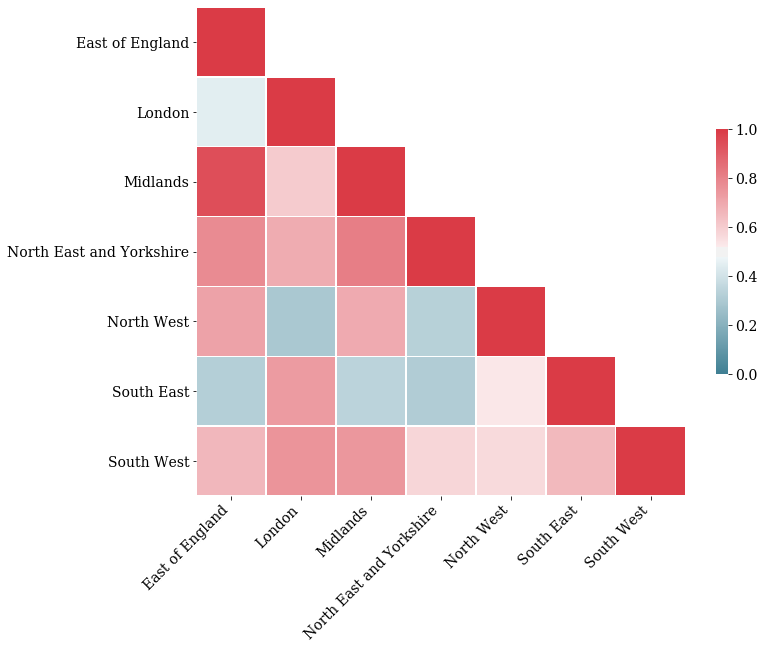

In [8]:
df = pd.DataFrame(new_cases.transpose(), columns=list(regions))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool), 1)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
_ = plt.xticks(rotation=45, ha='right')
plt.savefig(os.path.join(save_dir, 'regional_correlation.pdf'))

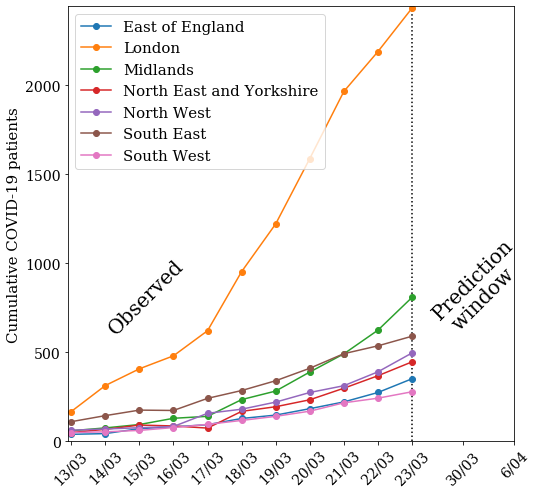

In [9]:
df = pd.DataFrame(cum_cases.transpose(), columns=list(regions))
df.plot(marker='o', figsize=(8, 8))
plt.plot([n_obs-1, n_obs-1], [0, df.max().max()+10], 'k:', zorder=0)
plt.xlim(-0.1, n_obs+1.1)
plt.ylim(0, df.max().max()+10)
support = np.concatenate((np.arange(n_obs), [n_obs+0.5, n_obs+2]))
plt.xticks(support, dates[:n_obs]+[dates[n_obs+6]]+[dates[n_obs+13]], rotation=45)
plt.ylabel('Cumulative COVID-19 patients')
plt.text(1, 600, 'Observed', size=20, rotation=45)
plt.text(n_obs-0.5, 600, 'Prediction\n window', size=20, rotation=45)
plt.savefig(os.path.join(save_dir, 'windows.pdf'))

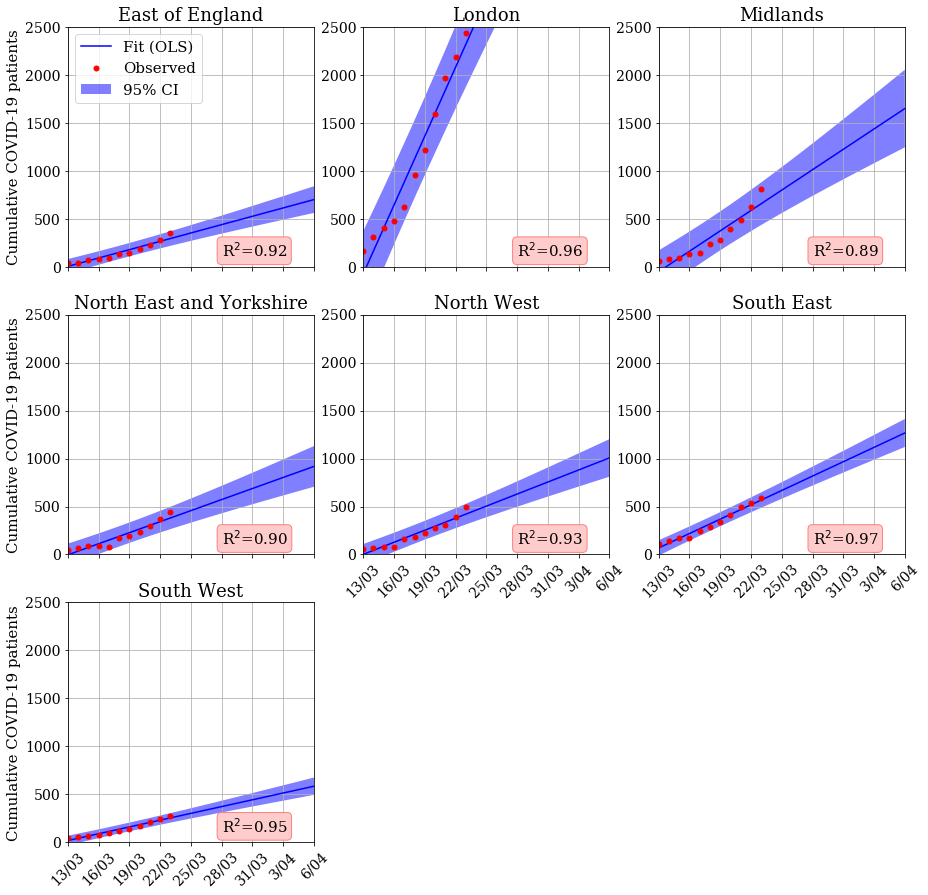

In [10]:
means, stds, exponents = regional_predictions(X, X_pred, cum_cases, regions, dates, ylabel='Cumulative COVID-19 patients', log=False)
plt.savefig(os.path.join(save_dir, 'new_patients_linear_fit.pdf'))

[0.21716538 0.26333369 0.26751834 0.22156301 0.22080125 0.17114957
 0.18642505]


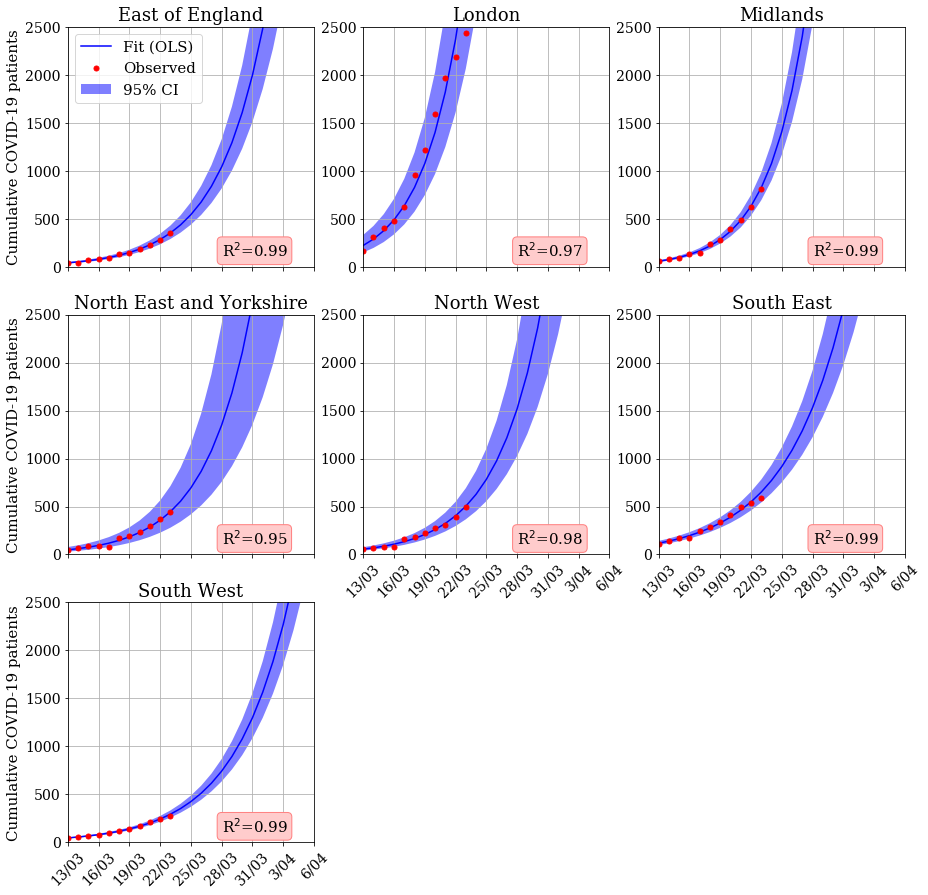

In [11]:
log_means, log_stds, exponents = regional_predictions(X, X_pred, cum_cases, regions, dates, ylabel='Cumulative COVID-19 patients', log=True)
exponents = np.array(exponents)
print(exponents)
plt.savefig(os.path.join(save_dir, 'new_patients_log-linear_fit.pdf'))

### LOS

In [12]:
beds = pd.read_csv(os.path.join(os.pardir, 'model_data', 'ICU_beds_region.csv'))['n_beds (2019)'].values
death_and_icu_info = pd.read_csv(os.path.join(os.pardir, 'model_data', 'hospitalisation_and_fatalities.csv'))
cfr = death_and_icu_info['Mortality Rate']
pct_need_icu = death_and_icu_info['Critical Care Needs Rate']

In [13]:
mu, sig = occupancy_arrays(log_means, log_stds, exponents, pct_need_icu,
                           icu_delay_normal_loc=2.0, los_gamma_shape=8.0, log=True)

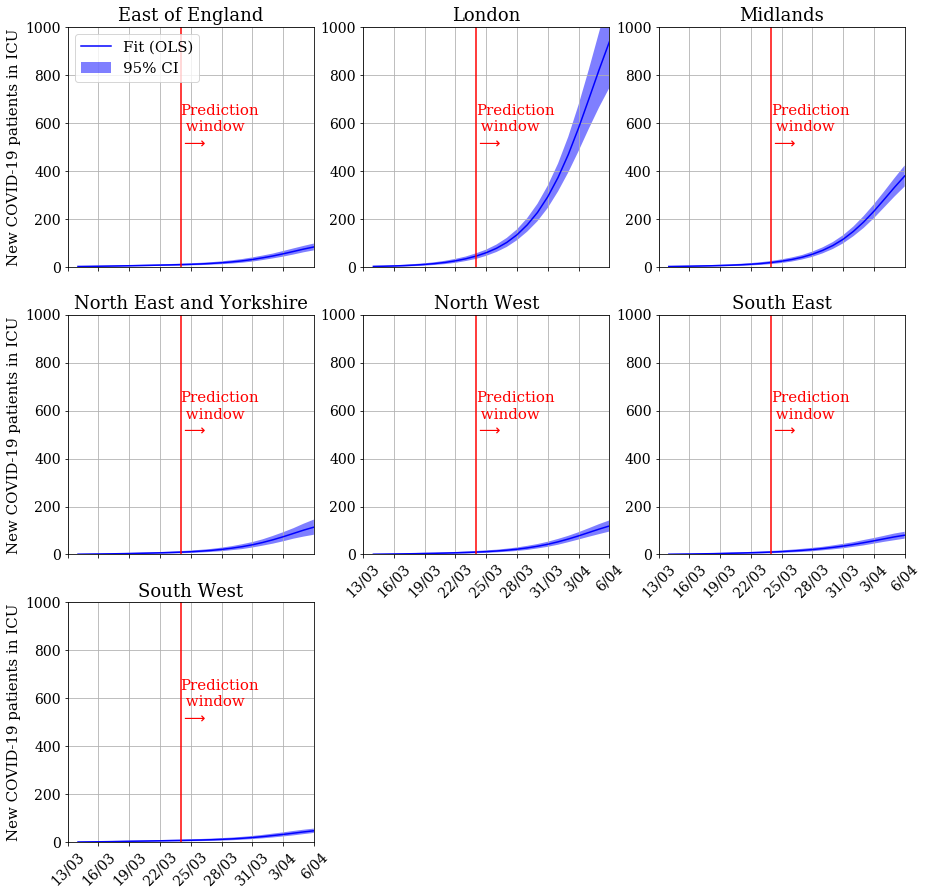

In [14]:
fig = plt.figure(figsize=(15, 15))
for i in range(len(regions)):
    ci_plot(new_cases[i], X_pred[1:, 1], mu[i], mu[i]-1.96*sig[i], mu[i]+1.96*sig[i], None,
            regions, dates, i, ylabel='New COVID-19 patients in ICU', obs=False)
plt.savefig(os.path.join(save_dir, 'covid_icu_patients.pdf'))

In [15]:
avg_occ = mu / beds[:, np.newaxis] * 100
std_occ = sig / beds[:, np.newaxis] * 100

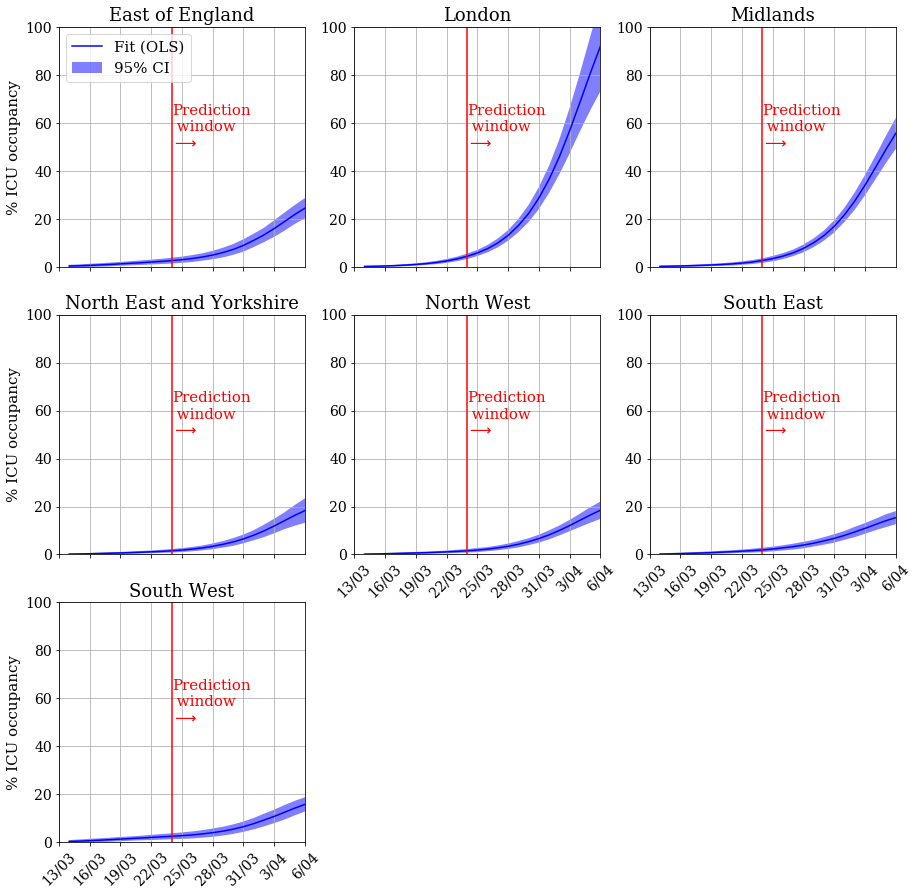

In [16]:
fig = plt.figure(figsize=(15, 15))
for i in range(len(regions)):
    ci_plot(new_cases[i], X_pred[1:, 1], avg_occ[i], avg_occ[i]-1.96*std_occ[i], avg_occ[i]+1.96*std_occ[i], None,
            regions, dates, i, ylabel='% ICU occupancy', obs=False, pct=True)
plt.savefig(os.path.join(save_dir, 'pct_covid_icu_occupancy.pdf'))